In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from prophet import Prophet
from openpyxl.workbook import Workbook
from matplotlib import pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import cx_Oracle
from config import oracle_wfm_key
import time
import datetime as dt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy.types import String
import ipynbname
from tqdm import tqdm
import itertools
import databases as db

ods = db.oracle('cco_wfm',oracle_wfm_key)

file = ipynbname.name()
output_path=r'\\Tds\Metrocom\Contact Center\Workforce Management\Forecasting Models\Forecast Outputs\\'

In [2]:
service = ['Wireline Sales and Service','Wireline Service QCB']
yesterday = dt.date.today() - dt.timedelta(days=1)
appended_data = []
for name in service:
    query = f'''SELECT "A1"."DateTime",
                "A1"."Queue",
                "A1"."Forecasted_AHT",
                "A1"."Forecasted_CV",
                "A1"."Actual_AHT",
                "A1"."Actual_CV"
        FROM "CCO_WFM"."Queue_Analytics" "A1"
        WHERE "A1"."Queue" = '{name}'
            AND "A1"."DateTime" <= TO_DATE('{yesterday}','YYYY-MM-DD')'''
    data = pd.read_sql(query, ods)
    appended_data.append(data)
appended_data = pd.concat(appended_data)
appended_data.head(3)

DateTime                       Queue  Forecasted_AHT  \
0 2017-09-20 09:00:00  Wireline Sales and Service             NaN   
1 2017-09-20 09:15:00  Wireline Sales and Service             NaN   
2 2017-09-20 09:30:00  Wireline Sales and Service             NaN   

   Forecasted_CV  Actual_AHT  Actual_CV  
0            NaN       554.0       50.0  
1            NaN       554.0       49.0  
2            NaN       750.0       37.0

## Volume Forecasts

In [3]:
grouped_cv = appended_data.groupby(['DateTime'])['Actual_CV'].sum()
grouped_cv = grouped_cv.reset_index()
grouped_cv.head(3)

DateTime  Actual_CV
0 2017-01-02 07:00:00       11.0
1 2017-01-02 07:15:00       10.0
2 2017-01-02 07:30:00       17.0

In [4]:
weekly_cv = grouped_cv.resample('d', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-02     1649.0
2017-01-03     2248.0
2017-01-04     1866.0

In [5]:
grouped_fcv = appended_data.groupby(['DateTime'])['Forecasted_CV'].sum()
grouped_fcv = grouped_fcv.reset_index()
grouped_fcv.head(3)

DateTime  Forecasted_CV
0 2017-01-02 07:00:00           12.0
1 2017-01-02 07:15:00           11.0
2 2017-01-02 07:30:00           14.0

In [6]:
weekly_fcv = grouped_fcv.resample('d', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02         1255.0
2017-01-03         1935.0
2017-01-04         1708.0

In [7]:
column_names = ['ds','for_y']
weekly_for = weekly_fcv.reset_index()
weekly_for.columns = column_names
weekly_for = weekly_for.replace(0,np.nan)
weekly_for.tail(3)

ds  for_y
2049 2022-08-13  539.0
2050 2022-08-14    NaN
2051 2022-08-15    NaN

In [8]:
column_names = ['ds','y']
weekly_data = weekly_cv.reset_index()
weekly_data.columns = column_names
weekly_data = weekly_data.replace(0,np.nan)
weekly_data.tail(3)

ds      y
2049 2022-08-13  569.0
2050 2022-08-14    NaN
2051 2022-08-15    NaN

#### Initiate Prophet

In [9]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=730, freq='d')
future.tail(3)

ds
2779 2024-08-12
2780 2024-08-13
2781 2024-08-14

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds         yhat   yhat_lower   yhat_upper
2779 2024-08-12  2580.103730  1823.371193  3192.976870
2780 2024-08-13  2186.740407  1425.643732  2771.409101
2781 2024-08-14  2019.557141  1281.839032  2633.462144

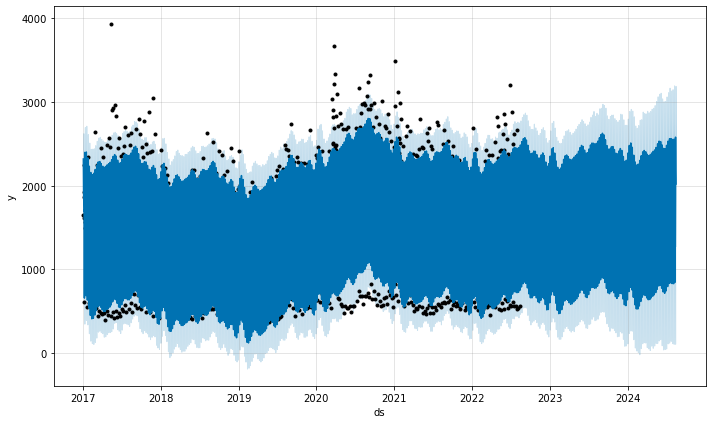

In [12]:
fig1 = m.plot(forecast)

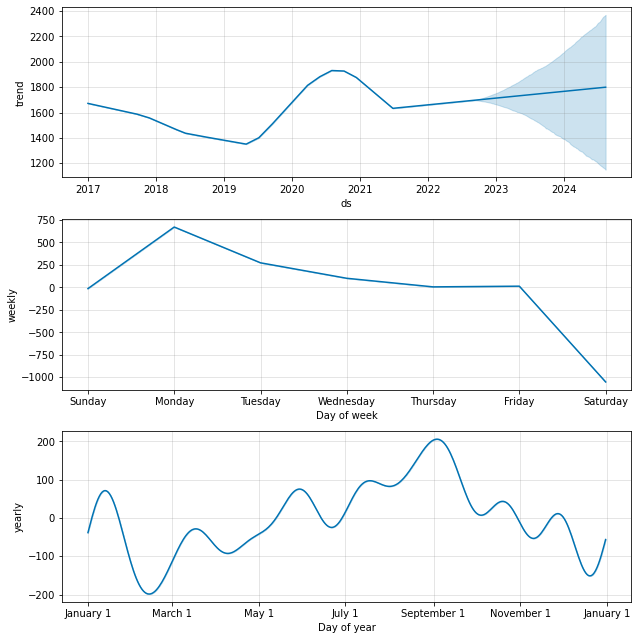

In [13]:
fig2 = m.plot_components(forecast)


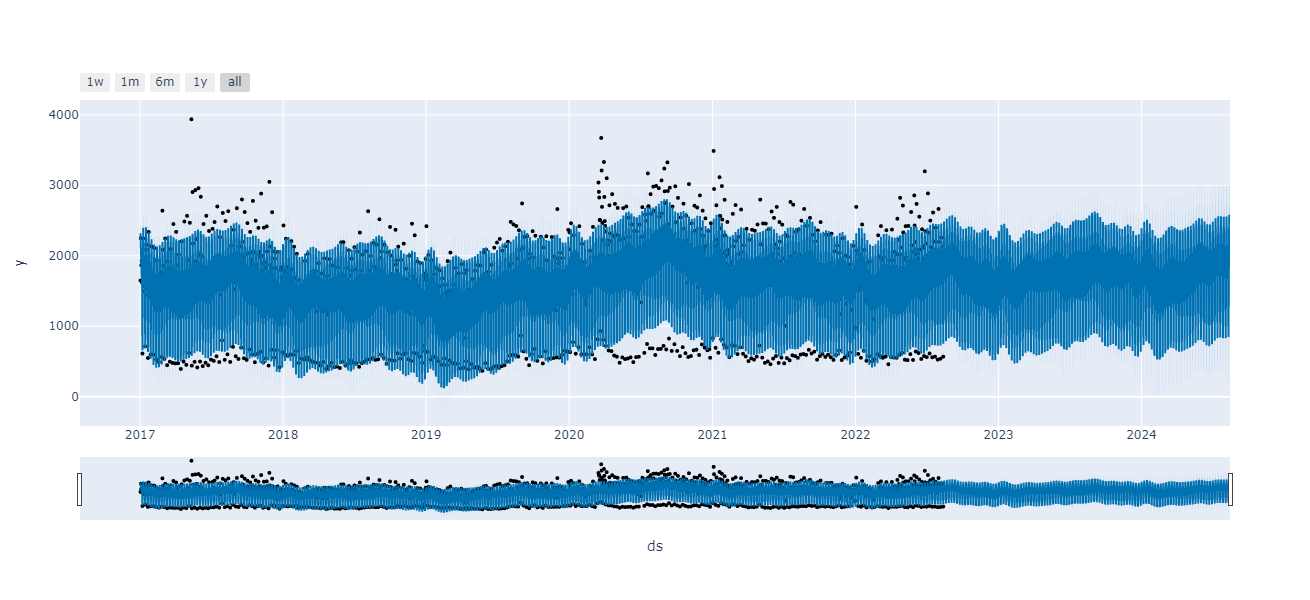

In [14]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

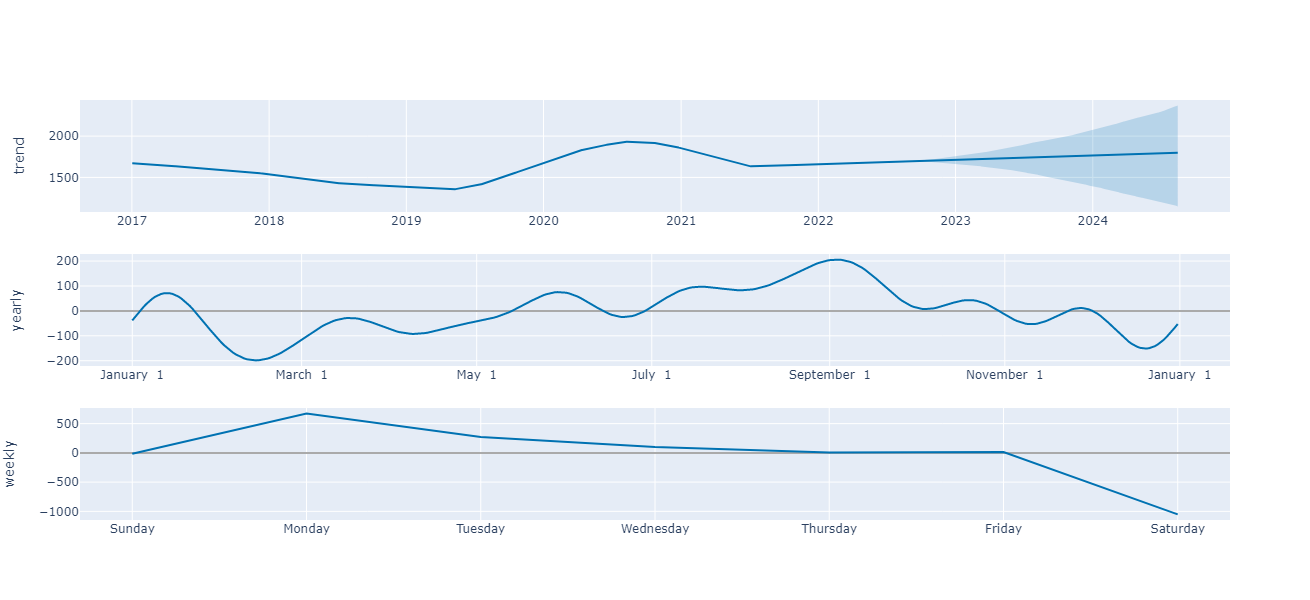

In [15]:
plot_components_plotly(m, forecast)


In [16]:
forecast.tail(3)

ds        trend   yhat_lower   yhat_upper  trend_lower  \
2779 2024-08-12  1799.164945  1823.371193  3192.976870  1152.408952   
2780 2024-08-13  1799.310643  1425.643732  2771.409101  1150.708803   
2781 2024-08-14  1799.456342  1281.839032  2633.462144  1149.008653   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2779  2366.909455      780.938785            780.938785            780.938785   
2780  2368.197381      387.429764            387.429764            387.429764   
2781  2369.485307      220.100800            220.100800            220.100800   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
2779  671.689457    671.689457    671.689457  109.249328    109.249328   
2780  273.487100    273.487100    273.487100  113.942664    113.942664   
2781  101.200506    101.200506    101.200506  118.900294    118.900294   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
2779    109.249328                   0.0                         0.0   
2780    113.942664                   0.0                         0.0   
2781    118.900294                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
2779                         0.0  2580.103730  
2780                         0.0  2186.740407  
2781                         0.0  2019.557141

#### Cross Validation

In [17]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 40 forecasts with cutoffs between 2021-01-14 00:00:00 and 2022-07-14 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper       y     cutoff
0 2021-01-15  1982.189233  1686.974967  2267.246482  1801.0 2021-01-14
1 2021-01-16   914.997040   609.811813  1212.132711   624.0 2021-01-14
2 2021-01-19  2174.758806  1880.399262  2470.020965  3114.0 2021-01-14

In [18]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon           mse        rmse         mae      mape     mdape     smape  \
0  4 days  71981.791616  268.294226  191.067628  0.179634  0.100328  0.173258   
1  5 days  95864.662961  309.620191  224.745235  0.161987  0.103814  0.157701   
2  6 days  93383.966909  305.587904  226.610425  0.114914  0.088985  0.115076   

   coverage  
0  0.876471  
1  0.801156  
2  0.747483

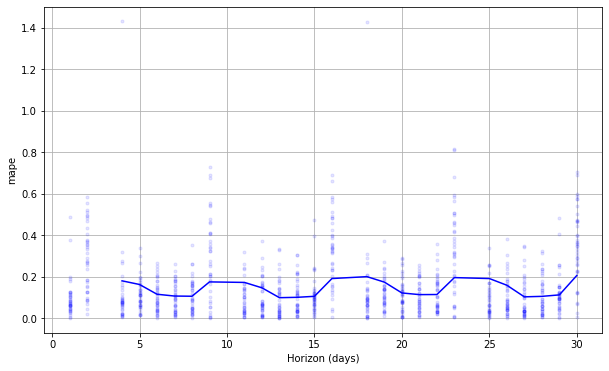

In [19]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

### SQL Export

In [20]:
# ods = db.oracle('cco_wfm',oracle_wfm_key)
# # add filename as column
# team = file.split('.')[0]
# forecast = forecast.merge(weekly_data, on='ds',how='left')
# forecast = forecast.merge(weekly_for, on='ds',how='left')
# forecast['Team'] = team

# # determine last row
# last_row = forecast['ds'].max()
# end_date = f"'{last_row}'"

# # remove duplicate rows before insert
# delete = f'''DELETE FROM
#                     "CCO_WFM"."Forecasts_Weekly" "A1"
#                 WHERE
#                     "A1"."Team" = '{team}'
                    
#                     AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

# with ods as conn:
#     conn.execute(delete)

In [21]:
# ods = db.oracle('cco_wfm',oracle_wfm_key)
# # Import forecast to database
# rows_imported = 0
# start_time = time.time()

# cols = forecast.dtypes[forecast.dtypes=='object'].index
# type_mapping = {col : String(100) for col in cols }

# print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
# forecast.to_sql('Forecasts_Weekly',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
# rows_imported += len(df)

# end_time = time.time() - start_time
# print(f'Done. {end_time} total seconds have elapsed.')

## AHT Forecasts

In [22]:
appended_data['Adj_AHT'] = appended_data['Actual_AHT'] * appended_data['Actual_CV']
appended_data['Adj_AHT'] = appended_data['Adj_AHT'].replace(0, np.nan)
grouped_aht = appended_data.groupby(['DateTime'])['Adj_AHT'].sum()
grouped_aht = grouped_aht.reset_index()
grouped_aht.head(3)

DateTime  Adj_AHT
0 2017-01-02 07:00:00   4202.0
1 2017-01-02 07:15:00   3820.0
2 2017-01-02 07:30:00   9061.0

In [23]:
combined_aht = grouped_aht
combined_aht['Actual_AHT'] = grouped_aht['Adj_AHT'] / grouped_cv['Actual_CV']
combined_aht.head(3)

DateTime  Adj_AHT  Actual_AHT
0 2017-01-02 07:00:00   4202.0       382.0
1 2017-01-02 07:15:00   3820.0       382.0
2 2017-01-02 07:30:00   9061.0       533.0

In [24]:
subdaily_adj = grouped_aht[['DateTime','Adj_AHT']]
subdaily_adj['Adj_AHT'] = subdaily_adj['Adj_AHT'].replace(0, np.nan)
weekly_adj = subdaily_adj.resample('d', on='DateTime').sum()
weekly_adj.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_8388\186402442.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_AHT
DateTime             
2017-01-02  1148137.0
2017-01-03  1399079.0
2017-01-04  1086792.0

In [25]:
subdaily_cv = grouped_cv[['DateTime','Actual_CV']]
weekly_cv = subdaily_cv.resample('d', on='DateTime').sum()
weekly_cv.head(3)

Actual_CV
DateTime             
2017-01-02     1649.0
2017-01-03     2248.0
2017-01-04     1866.0

In [27]:
combined_aht = weekly_adj.drop(columns=['Adj_AHT'])
combined_aht['Actual_AHT'] = weekly_adj['Adj_AHT'] / weekly_cv['Actual_CV']
column_names = ['ds','y']
weekly_data = combined_aht.reset_index()
weekly_data.columns = column_names
weekly_data.tail(3)

ds           y
2049 2022-08-13  500.778559
2050 2022-08-14         NaN
2051 2022-08-15         NaN

In [28]:
appended_data['Adj_for'] = appended_data['Forecasted_AHT'] * appended_data['Forecasted_CV']
appended_data['Adj_for'] = appended_data['Adj_for'].replace(0, np.nan)
grouped_for = appended_data.groupby(['DateTime'])['Adj_for'].sum()
grouped_for = grouped_for.reset_index()
grouped_for.head(3)

DateTime  Adj_for
0 2017-01-02 07:00:00   3888.0
1 2017-01-02 07:15:00   4268.0
2 2017-01-02 07:30:00   6664.0

In [29]:
combined_for = grouped_for
combined_for['Forecasted_AHT'] = grouped_for['Adj_for'] / grouped_fcv['Forecasted_CV']
combined_for.head(3)

DateTime  Adj_for  Forecasted_AHT
0 2017-01-02 07:00:00   3888.0           324.0
1 2017-01-02 07:15:00   4268.0           388.0
2 2017-01-02 07:30:00   6664.0           476.0

In [30]:
subdaily_for = grouped_for[['DateTime','Adj_for']]
subdaily_for['Adj_for'] = subdaily_for['Adj_for'].replace(0, np.nan)
weekly_adj_for = subdaily_for.resample('d', on='DateTime').sum()
weekly_adj_for.head(3)

C:\Users\usrocu\AppData\Local\Temp\ipykernel_8388\4084095214.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Adj_for
DateTime             
2017-01-02   762690.0
2017-01-03  1105252.0
2017-01-04   961130.0

In [31]:
subdaily_fcv = grouped_fcv[['DateTime','Forecasted_CV']]
weekly_fcv = subdaily_fcv.resample('d', on='DateTime').sum()
weekly_fcv.head(3)

Forecasted_CV
DateTime                 
2017-01-02         1255.0
2017-01-03         1935.0
2017-01-04         1708.0

In [32]:
combined_for = weekly_adj_for.drop(columns=['Adj_for'])
combined_for['Forecasted_AHT'] = weekly_adj_for['Adj_for'] / weekly_fcv['Forecasted_CV']
column_names = ['ds','for_y']
weekly_for_aht = combined_for.reset_index()
weekly_for_aht.columns = column_names
weekly_for_aht.tail(3)

ds       for_y
2049 2022-08-13  614.397032
2050 2022-08-14         NaN
2051 2022-08-15         NaN

#### Initiate Prophet

In [33]:
df = weekly_data
m = Prophet() 
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
future = m.make_future_dataframe(periods=730, freq='d')
future.tail(3)

ds
2779 2024-08-12
2780 2024-08-13
2781 2024-08-14

In [35]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)


ds        yhat  yhat_lower   yhat_upper
2779 2024-08-12  993.869548  646.072995  1303.482203
2780 2024-08-13  964.972917  629.643869  1270.565834
2781 2024-08-14  966.590760  633.640756  1275.192491

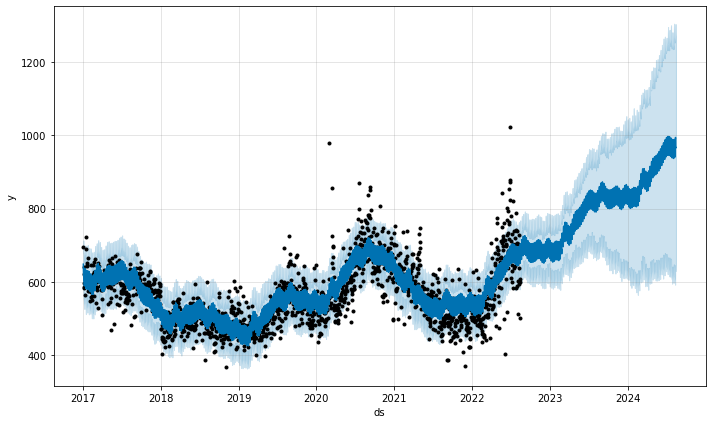

In [36]:
fig1 = m.plot(forecast)

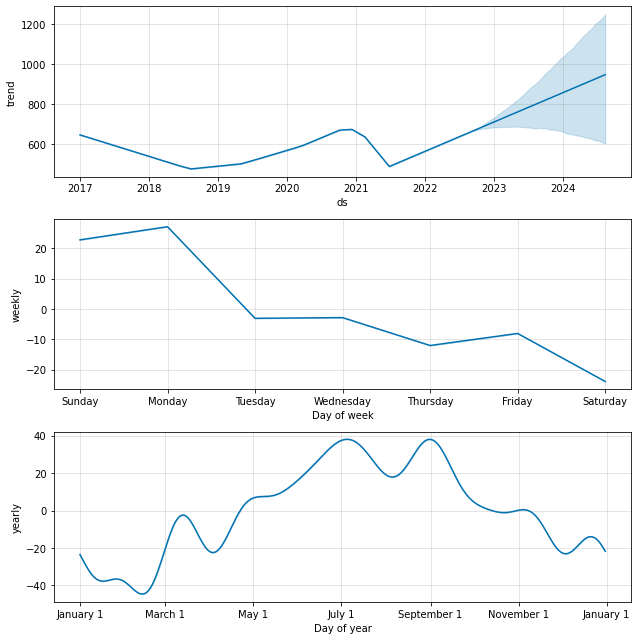

In [37]:
fig2 = m.plot_components(forecast)


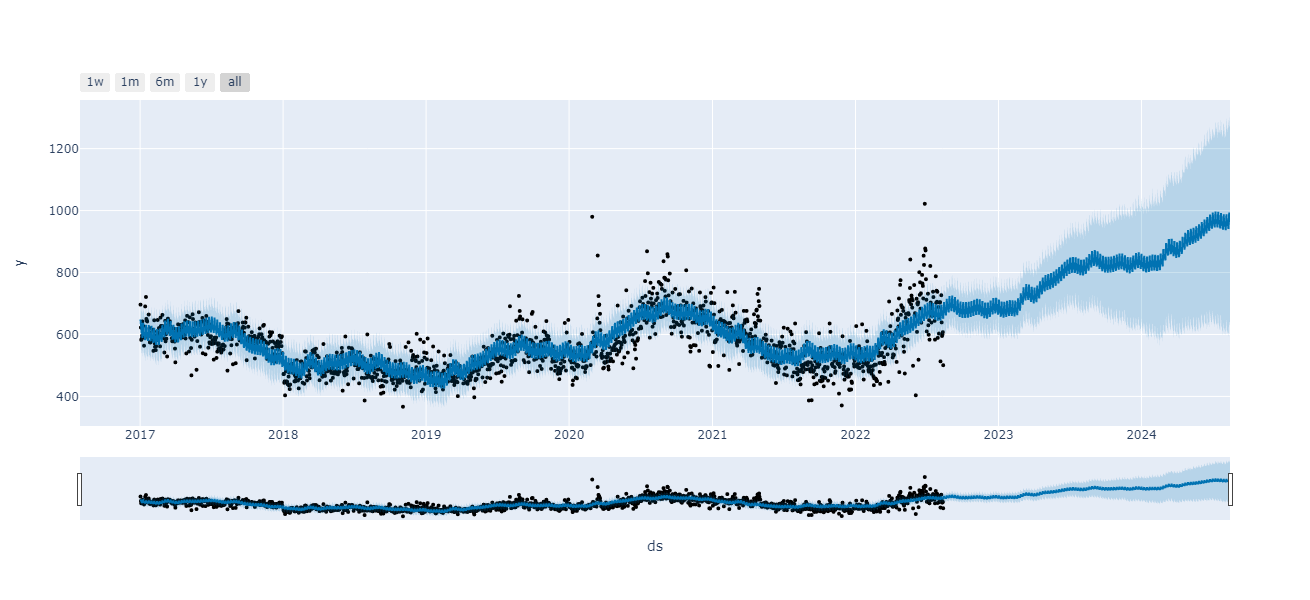

In [38]:
fig = plot_plotly(m, forecast)
plot_plotly(m, forecast)

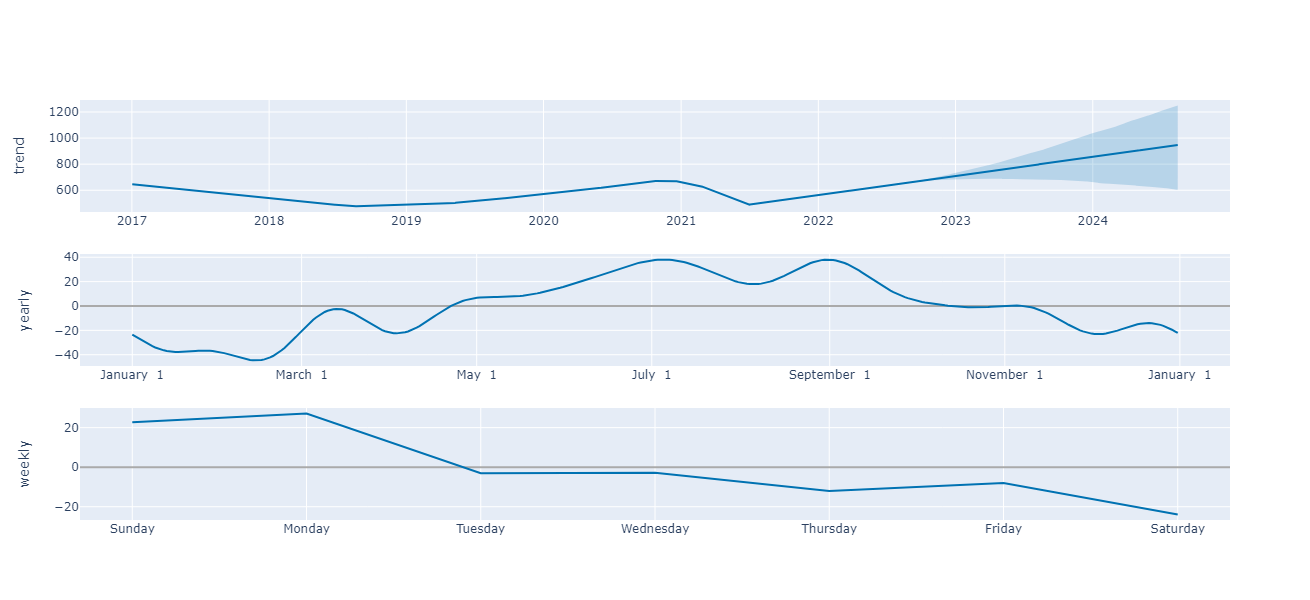

In [39]:
plot_components_plotly(m, forecast)


In [40]:
forecast.tail(3)

ds       trend  yhat_lower   yhat_upper  trend_lower  \
2779 2024-08-12  945.942819  646.072995  1303.482203   603.643826   
2780 2024-08-13  946.343856  629.643869  1270.565834   603.510539   
2781 2024-08-14  946.744893  633.640756  1275.192491   603.382774   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2779  1246.579969       47.926729             47.926729             47.926729   
2780  1247.988937       18.629061             18.629061             18.629061   
2781  1249.063200       19.845868             19.845868             19.845868   

         weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
2779  27.109967     27.109967     27.109967  20.816762     20.816762   
2780  -3.074255     -3.074255     -3.074255  21.703316     21.703316   
2781  -2.837105     -2.837105     -2.837105  22.682973     22.682973   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
2779     20.816762                   0.0                         0.0   
2780     21.703316                   0.0                         0.0   
2781     22.682973                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
2779                         0.0  993.869548  
2780                         0.0  964.972917  
2781                         0.0  966.590760

#### Cross Validate

In [41]:
# create cross-validation df
df_cv = cross_validation(m, initial='1461 days', period='14 days', horizon = '30 days')
df_cv.head(3)

INFO:prophet:Making 40 forecasts with cutoffs between 2021-01-14 00:00:00 and 2022-07-14 00:00:00


  0%|          | 0/40 [00:00<?, ?it/s]

ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2021-01-15  635.721160  576.203073  691.760508  600.135480 2021-01-14
1 2021-01-16  626.045051  565.765359  681.917722  498.322115 2021-01-14
2 2021-01-19  639.021411  585.529256  692.240170  674.247592 2021-01-14

In [42]:
# create performance metrics df
df_p = performance_metrics(df_cv)
df_p.head(3)

horizon          mse       rmse        mae      mape     mdape     smape  \
0  4 days  9483.916002  97.385399  77.204492  0.134629  0.116580  0.137488   
1  5 days  9704.110863  98.509446  77.146535  0.131052  0.116189  0.135956   
2  6 days  8919.127696  94.441133  74.391949  0.125092  0.116334  0.131232   

   coverage  
0  0.422059  
1  0.440171  
2  0.459989

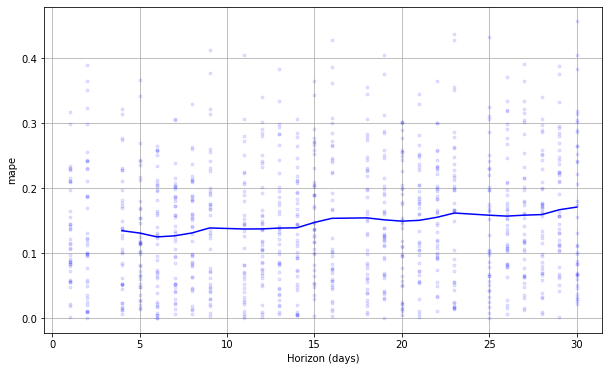

In [43]:
# plot cross-validation
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [44]:
# ods = db.oracle('cco_wfm',oracle_wfm_key)
# # add filename as column
# team = file.split('.')[0]
# forecast = forecast.merge(weekly_data, on='ds',how='left')
# forecast = forecast.merge(weekly_for_aht, on='ds',how='left')
# forecast['Team'] = team

# # determine last row
# last_row = forecast['ds'].max()
# end_date = f"'{last_row}'"

# # remove duplicate rows before insert
# delete = f'''DELETE FROM
#                     "CCO_WFM"."Forecasts_Weekly_AHT" "A1"
#                 WHERE
#                     "A1"."Team" = '{team}'
                    
#                     AND "A1"."DS" <= TO_DATE({end_date},'YYYY-MM-DD HH24:MI:SS')'''

# with ods as conn:
#     conn.execute(delete)

In [45]:
# ods = db.oracle('cco_wfm',oracle_wfm_key)
# # Import forecast to database
# rows_imported = 0
# start_time = time.time()

# cols = forecast.dtypes[forecast.dtypes=='object'].index
# type_mapping = {col : String(100) for col in cols }

# print(f'importing rows {rows_imported} to {rows_imported + len(forecast)}...', end='')
# forecast.to_sql('Forecasts_Weekly_AHT',ods,schema='CCO_WFM',if_exists='append',index=False,dtype=type_mapping)
# rows_imported += len(df)

# end_time = time.time() - start_time
# print(f'Done. {end_time} total seconds have elapsed.')